In [2]:
import numpy as np
from sklearn.model_selection import train_test_split


import numpy as np
from scipy.ndimage import measurements
import scipy.io as sio
import glob
import cv2

import os
from skimage import data, io
from matplotlib import pyplot as plt

In [10]:
combined_training_data_dir = r".\dataset\training_data\combined\train/"
combined_test_imgs_data_dir = r".\dataset\training_data\combined\test\imgs/"
combined_test_mat_data_dir = r".\dataset\training_data\combined\test\mat/"
combined_valid_data_dir = r".\dataset\training_data\combined\valid/"

offset_train = 1
offset_test = 1
offset_valid = 1

# Split PanNuke and Convert to ConSeP Format

In [11]:
# Code for Generating Training and Test Data in npy
def convert_and_save(images, masks, output_dir, offset):
    uniques = []
    for idx, (image, mask) in enumerate(zip(images,masks)):
        sample = np.zeros((256,256,5))
        temp = np.roll(mask,1,axis=2)
        #print(image.shape,mask.shape)
#         temp = mask[:,:,::-1]
        sample[:,:,:3] = image
        sample[:,:,3] = np.sum(temp[:,:,1:],axis=2)  # Instance
        sample[:,:,4] = np.argmax(temp,axis=2) # Class
        
        uniques.append(sample[:,:,4])
        np.save(output_dir + str(idx+offset) + ".npy", sample)
        
        #print(np.unique(sample[:,:,4]))
        #break
    uniques = np.array(uniques)
    print(np.unique(uniques,return_counts=True))

In [23]:
def get_inst_centroid(inst_map):
    inst_centroid_list = []
    inst_id_list = list(np.unique(inst_map))
    for inst_id in inst_id_list[1:]: # avoid 0 i.e background
        mask = np.array(inst_map == inst_id, np.uint8)
        inst_moment = cv2.moments(mask)
        inst_centroid = [(inst_moment["m10"] / inst_moment["m00"]),
                         (inst_moment["m01"] / inst_moment["m00"])]
        inst_centroid_list.append(inst_centroid)
    return np.array(inst_centroid_list)

In [21]:
# Save Test PNG
def generate_png_test(images,output_dir, offset):
    for idx, image in enumerate(images):
        io.imsave(output_dir + str(idx+offset) + ".png", image.astype(np.uint8))
    
    
# Code for Generating GT data to be utilized the compute_stats.py script

def save_instance_maps(masks, output_dir,offset):
    count = 0
    for idx, mask in enumerate(masks):
        temp = np.roll(mask,1,axis=2)

        inst_map = np.sum(temp[:,:,1:],axis=2)  # Instance
        type_map = np.argmax(temp,axis=2) # Class
        inst_centroid = get_inst_centroid(inst_map)
        inst_type = np.zeros((inst_centroid.shape[0],1))

        centroids_img = np.zeros((inst_map.shape[0],inst_map.shape[1]))
        for idx1 , cent in enumerate(inst_centroid):
            inst_type[idx1,0] = type_map[int(cent[1]),int(cent[0])]
        # print(inst_centroid.shape)

        if inst_centroid.shape[0] == 0:
            count += 1

        sio.savemat(output_dir + str(idx+offset) + ".mat", {'inst_map': inst_map, 'type_map': type_map, 'inst_centroid': inst_centroid, 'inst_type': inst_type})
    # print(count)  


## Fold 1 PanNuke

In [12]:
images_file_fold1 = r".\dataset\PanNuke\Fold 1\images\fold1\images.npy"
masks_file_fold1 = r".\dataset\PanNuke\Fold 1\masks\fold1\masks.npy"

X1 = np.load(images_file_fold1)
Y1 = np.load(masks_file_fold1)

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, Y1, test_size=0.3, random_state=26)

In [13]:
print(X1_train.shape)
print(X1_test.shape)
print(y1_train.shape)
print(y1_test.shape)

(1859, 256, 256, 3)
(797, 256, 256, 3)
(1859, 256, 256, 6)
(797, 256, 256, 6)


In [14]:
#Training Data Output
convert_and_save(X1_train,y1_train,combined_training_data_dir,offset_train)
#Valid Data CoNSeP format
convert_and_save(X1_test,y1_test,combined_valid_data_dir, offset_valid)

(array([0., 1., 2., 3., 4., 5.]), array([101067621,  11032980,   2147574,   4492884,     95508,   2994857],
      dtype=int64))
(array([0., 1., 2., 3., 4., 5.]), array([43336421,  4685287,   966994,  1948491,    18282,  1276717],
      dtype=int64))


In [24]:
#Save the png and mat
generate_png_test(X1_test,combined_test_imgs_data_dir,offset_test)
#Save MAT
save_instance_maps(y1_test,combined_test_mat_data_dir,offset_test)

C:\Users\Tasli\anaconda3\envs\hovernet\lib\site-packages\ipykernel_launcher.py:4: UserWarning: .\dataset\training_data\combined\test\imgs/115.png is a low contrast image
  after removing the cwd from sys.path.
C:\Users\Tasli\anaconda3\envs\hovernet\lib\site-packages\ipykernel_launcher.py:4: UserWarning: .\dataset\training_data\combined\test\imgs/309.png is a low contrast image
  after removing the cwd from sys.path.
C:\Users\Tasli\anaconda3\envs\hovernet\lib\site-packages\ipykernel_launcher.py:4: UserWarning: .\dataset\training_data\combined\test\imgs/352.png is a low contrast image
  after removing the cwd from sys.path.
C:\Users\Tasli\anaconda3\envs\hovernet\lib\site-packages\ipykernel_launcher.py:4: UserWarning: .\dataset\training_data\combined\test\imgs/414.png is a low contrast image
  after removing the cwd from sys.path.
C:\Users\Tasli\anaconda3\envs\hovernet\lib\site-packages\ipykernel_launcher.py:4: UserWarning: .\dataset\training_data\combined\test\imgs/660.png is a low contr

In [15]:
offset_train += len(X1_train)
offset_test += len(X1_test)
offset_valid += len(X1_test)

print(offset_train)
print(offset_test)
print(offset_valid)

1860
798
798


In [25]:
#Clear Memory
X1_train= None
X1_test = None
y1_train= None
y1_test= None
X1=None
Y1=None
del X1_train
del X1_test 
del y1_train
del y1_test
del X1
del Y1

## Fold 2 PanNuke

In [29]:
images_file_fold2 = r".\dataset\PanNuke\Fold 2\images\fold2\images.npy"
masks_file_fold2 = r".\dataset\PanNuke\Fold 2\masks\fold2\masks.npy"

X2 = np.load(images_file_fold2)
Y2 = np.load(masks_file_fold2)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, Y2, test_size=0.3, random_state=26)

In [30]:
print(X2_train.shape)
print(X2_test.shape)
print(y2_train.shape)
print(y2_test.shape)

(1766, 256, 256, 3)
(757, 256, 256, 3)
(1766, 256, 256, 6)
(757, 256, 256, 6)


In [32]:
#Training Data Output
convert_and_save(X2_train,y2_train,combined_training_data_dir,offset_train)
#Valid Data CoNSeP format
convert_and_save(X2_test,y2_test,combined_valid_data_dir, offset_valid)

(array([0., 1., 2., 3., 4., 5.]), array([97013332,  8996690,  2198776,  4497307,    71624,  2958847],
      dtype=int64))
(array([0., 1., 2., 3., 4., 5.]), array([41647899,  4021084,   813015,  1838986,    32348,  1257420],
      dtype=int64))


In [33]:
#Save the png and mat
generate_png_test(X2_test,combined_test_imgs_data_dir,offset_test)
#Save MAT
save_instance_maps(y2_test,combined_test_mat_data_dir,offset_test)

C:\Users\Tasli\anaconda3\envs\hovernet\lib\site-packages\ipykernel_launcher.py:4: UserWarning: .\dataset\training_data\combined\test\imgs/955.png is a low contrast image
  after removing the cwd from sys.path.
C:\Users\Tasli\anaconda3\envs\hovernet\lib\site-packages\ipykernel_launcher.py:4: UserWarning: .\dataset\training_data\combined\test\imgs/970.png is a low contrast image
  after removing the cwd from sys.path.
C:\Users\Tasli\anaconda3\envs\hovernet\lib\site-packages\ipykernel_launcher.py:4: UserWarning: .\dataset\training_data\combined\test\imgs/1036.png is a low contrast image
  after removing the cwd from sys.path.
C:\Users\Tasli\anaconda3\envs\hovernet\lib\site-packages\ipykernel_launcher.py:4: UserWarning: .\dataset\training_data\combined\test\imgs/1126.png is a low contrast image
  after removing the cwd from sys.path.
C:\Users\Tasli\anaconda3\envs\hovernet\lib\site-packages\ipykernel_launcher.py:4: UserWarning: .\dataset\training_data\combined\test\imgs/1392.png is a low co

In [34]:
offset_train += len(X2_train)
offset_test += len(X2_test)
offset_valid += len(X2_test)

print(offset_train)
print(offset_test)
print(offset_valid)

3626
1555
1555


In [35]:
#Clear Memory
X2_train= None
X2_test = None
y2_train= None
y2_test= None
X2=None
Y2=None
del X2_train
del X2_test 
del y2_train
del y2_test
del X2
del Y2

## Fold 3 PanNuke

In [36]:
images_file_fold3 = r".\dataset\PanNuke\Fold 3\images\fold3\images.npy"
masks_file_fold3 = r".\dataset\PanNuke\Fold 3\masks\fold3\masks.npy"

X3 = np.load(images_file_fold3)
Y3 = np.load(masks_file_fold3)

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, Y3, test_size=0.3, random_state=26)

In [37]:
print(X3_train.shape)
print(X3_test.shape)
print(y3_train.shape)
print(y3_test.shape)

(1905, 256, 256, 3)
(817, 256, 256, 3)
(1905, 256, 256, 6)
(817, 256, 256, 6)


In [38]:
#Training Data Output
convert_and_save(X3_train,y3_train,combined_training_data_dir,offset_train)
#Valid Data CoNSeP format
convert_and_save(X3_test,y3_test,combined_valid_data_dir, offset_valid)

(array([0., 1., 2., 3., 4., 5.]), array([103569332,  11356034,   2148944,   4524357,    107361,   3140052],
      dtype=int64))
(array([0., 1., 2., 3., 4., 5.]), array([44599007,  4758013,   911868,  2046524,    32885,  1194615],
      dtype=int64))


In [39]:
#Save the png and mat
generate_png_test(X3_test,combined_test_imgs_data_dir,offset_test)
#Save MAT
save_instance_maps(y3_test,combined_test_mat_data_dir,offset_test)

C:\Users\Tasli\anaconda3\envs\hovernet\lib\site-packages\ipykernel_launcher.py:4: UserWarning: .\dataset\training_data\combined\test\imgs/1629.png is a low contrast image
  after removing the cwd from sys.path.
C:\Users\Tasli\anaconda3\envs\hovernet\lib\site-packages\ipykernel_launcher.py:4: UserWarning: .\dataset\training_data\combined\test\imgs/1664.png is a low contrast image
  after removing the cwd from sys.path.
C:\Users\Tasli\anaconda3\envs\hovernet\lib\site-packages\ipykernel_launcher.py:4: UserWarning: .\dataset\training_data\combined\test\imgs/1763.png is a low contrast image
  after removing the cwd from sys.path.
C:\Users\Tasli\anaconda3\envs\hovernet\lib\site-packages\ipykernel_launcher.py:4: UserWarning: .\dataset\training_data\combined\test\imgs/1770.png is a low contrast image
  after removing the cwd from sys.path.
C:\Users\Tasli\anaconda3\envs\hovernet\lib\site-packages\ipykernel_launcher.py:4: UserWarning: .\dataset\training_data\combined\test\imgs/1779.png is a low 

In [40]:
offset_train += len(X3_train)
offset_test += len(X3_test)
offset_valid += len(X3_test)

print(offset_train)
print(offset_test)
print(offset_valid)

5531
2372
2372


In [ ]:
#Clear Memory
X3_train= None
X3_test = None
y3_train= None
y3_test= None
X3=None
Y3=None
del X3_train
del X3_test 
del y3_train
del y3_test
del X3
del Y3

# Split CoNSeP

#### Consep we can just save the testing data and then run extract patches on the new training data - no need to manually do the format

In [42]:
original_test_dir = r"dataset\CoNSeP\Test\Images/"
original_train_dir = r"dataset\CoNSeP\Train\Images/"

list_original_test = os.listdir(original_test_dir)
list_original_train = os.listdir(original_train_dir)

print(len(list_original_test))
print(len(list_original_train))

14
27


In [61]:
combine_list_original = np.concatenate((list_original_test, list_original_train), axis=None)
print(combine_list_original.shape)

(41,)


In [62]:
#Randomize
np.random.shuffle(combine_list_original)

In [63]:
new_training_data, new_testing_data = np.split(combine_list_original,[int(0.7 * len(combine_list_original))])

print(new_training_data.shape)
print(new_testing_data.shape)

(28,)
(13,)


### Process Test Data

In [8]:
from shutil import copyfile

In [70]:
image_folders = [r"dataset\CoNSeP\Test\Images/",r"dataset\CoNSeP\Train\Images/"]
img_output_consep = r".\dataset\training_data\combined\consep_test_processed\Images/"

In [71]:
for folder in image_folders:
    files = os.listdir(folder)
    for file in files:
        if file in new_testing_data:
            new_name = str(offset_test)+'.png'
            copyfile(os.path.join(folder,file), os.path.join(img_output_consep,new_name))
            offset_test+=1

print(offset_test)

2385


In [78]:
new_testing_data = new_testing_data.tolist()

In [81]:
## Process to be mat
new_testing_data = [x[:-3] +"mat" for x in new_testing_data]

In [73]:
labels_folders = [r"dataset\CoNSeP\Test\Labels/",r"dataset\CoNSeP\Train\Labels/"]
lbl_output_consep = r".\dataset\training_data\combined\consep_test_processed\Labels/"

In [83]:
count = 0
for folder in labels_folders:
    files = os.listdir(folder)
    for file in files:
        if file in new_testing_data:
            new_name = str(offset_valid+count)+'.mat'
            copyfile(os.path.join(folder,file), os.path.join(lbl_output_consep,new_name))
            count+=1

print(count)

13


In [84]:
## Process to be png
new_testing_data = [x[:-3] +"png" for x in new_testing_data]

In [89]:
overlay_folders = [r"dataset\CoNSeP\Test\Overlay/",r"dataset\CoNSeP\Train\Overlay/"]
ovl_output_consep = r".\dataset\training_data\combined\consep_test_processed\Overlay/"

In [90]:
count = 0
for folder in overlay_folders:
    files = os.listdir(folder)
    for file in files:
        if file in new_testing_data:
            new_name = str(offset_valid+count)+'.png'
            copyfile(os.path.join(folder,file), os.path.join(ovl_output_consep,new_name))
            count+=1

print(count)

13


## Process Training Data

In [92]:
image_folders = [r"dataset\CoNSeP\Test\Images/",r"dataset\CoNSeP\Train\Images/"]
img_output_consep = r"dataset\training_data\combined\consep_training_to_be_processed\Images/"

In [93]:
count = 0
for folder in image_folders:
    files = os.listdir(folder)
    for file in files:
        if file in new_training_data:
            new_name = str(offset_train + count)+'.png'
            copyfile(os.path.join(folder,file), os.path.join(img_output_consep,new_name))
            count +=1

print(count)

28


In [94]:
overlay_folders = [r"dataset\CoNSeP\Test\Overlay/",r"dataset\CoNSeP\Train\Overlay/"]
ovl_output_consep = r".\dataset\training_data\combined\consep_training_to_be_processed\Overlay/"

In [96]:
count = 0
for folder in overlay_folders:
    files = os.listdir(folder)
    for file in files:
        if file in new_training_data:
            new_name = str(offset_train+count)+'.png'
            copyfile(os.path.join(folder,file), os.path.join(ovl_output_consep,new_name))
            count+=1

print(count)

28


In [98]:
new_training_data = new_training_data.tolist()
## Process to be mat
new_training_data = [x[:-3] +"mat" for x in new_training_data]

In [100]:
labels_folders = [r"dataset\CoNSeP\Test\Labels/",r"dataset\CoNSeP\Train\Labels/"]
lbl_output_consep = r".\dataset\training_data\combined\consep_training_to_be_processed\Labels/"

In [101]:
count = 0
for folder in labels_folders:
    files = os.listdir(folder)
    for file in files:
        if file in new_training_data:
            new_name = str(offset_train+count)+'.mat'
            copyfile(os.path.join(folder,file), os.path.join(lbl_output_consep,new_name))
            count+=1

print(count)

28


### Run extract_patches.py on the new consep data

### Rename the genrated files. CoNSeP will start from 5531

In [4]:
start = 5531
#FOR TRAINING DATA
file_dir = r"dataset\training_data\combined\consep_processed\consep\consep\train\256x256_164x164"
out_dir = r"dataset\training_data\combined\train"

list1 = os.listdir(file_dir)

print(len(list1))

1372


In [9]:
count = 0
for file_name in list1:
    new_name = str(start+count) +".npy"
    copyfile(os.path.join(file_dir,file_name),os.path.join(out_dir,new_name))
    count+=1

In [10]:
#FOR Validation DATA
start = 2372
file_dir = r"dataset\training_data\combined\consep_processed\consep\consep\valid\256x256_164x164"
out_dir = r"dataset\training_data\combined\valid"

list1 = os.listdir(file_dir)

print(len(list1))

637


In [11]:
count = 0
for file_name in list1:
    new_name = str(start+count) +".npy"
    copyfile(os.path.join(file_dir,file_name),os.path.join(out_dir,new_name))
    count+=1

### Final Sanity Format check of the combination

In [18]:
#This patch came from PanNuke
file_pannuke = r"dataset\training_data\combined\train\1.npy"
datapannuke = np.load(file_pannuke)
print(datapannuke.shape)

(256, 256, 5)


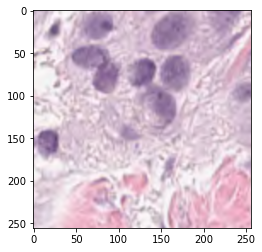

In [20]:
rgb = datapannuke[:, :, 0:3]
rgb = rgb.astype(int)
plt.imshow(rgb)
plt.show()

In [15]:
#This patch came from CoNSeP
file_consep = r"dataset\training_data\combined\train\6900.npy"
dataconsep = np.load(file_consep)
print(dataconsep.shape)

(256, 256, 5)


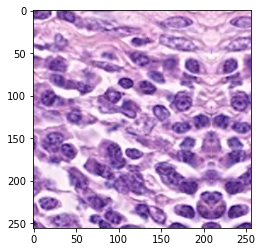

In [16]:
rgb = dataconsep[:, :, 0:3]
plt.imshow(rgb)
plt.show()

We observe that the values range from 0 (background) to N where N is the number of classes. See below what these values refer to for different datasets.

0 refers to no-labels. We replace some of the original CoNSeP labels to form our new label classes as defined below.

## Combined Dataset Labels

1) Neoplastic <br />
2) Inflammatory <br />
3) Connective <br />
4) Dead <br />
5) Non-Neoplastic Epithelial <br /> 
6) Epithelial <br />
7) Spindle-Shaped <br />
8) Miscellaneous
## CoNSeP (orginal)

1) Epithelial (convert to 6) <br />
2) Inflammatory (leave as 2) <br />
3) Spindle-Shaped (convert to 7) <br />
4) Miscellaneous (convert to 8)

## PanNuke (orginal)

1) Neoplastic <br />
2) Inflammatory <br />
3) Connective <br />
4) Dead <br />
5) Non-Neoplastic Epithelial 

In [4]:
train_dir = r"dataset\training_data\combined\train"

In [15]:
start = 5531
end = 6902
for i in range(start,end+1):
    file_name = os.path.join(train_dir, str(i)+".npy")
    data = np.load(file_name)
    ch5 = data[:, :, 4]
    
    ch5 = np.where(ch5 == 1, 6, ch5)
    ch5 = np.where(ch5 == 3, 7, ch5)
    ch5 = np.where(ch5 == 4, 8, ch5)
    
    data[:, :, 4] = ch5
    np.save(file_name, data)

In [ ]:
# Repeat for Validation data

In [16]:
valid_dir = r"dataset\training_data\combined\valid"

In [17]:
start = 2372
end = 3008
for i in range(start,end+1):
    file_name = os.path.join(valid_dir, str(i)+".npy")
    data = np.load(file_name)
    ch5 = data[:, :, 4]
    
    ch5 = np.where(ch5 == 1, 6, ch5)
    ch5 = np.where(ch5 == 3, 7, ch5)
    ch5 = np.where(ch5 == 4, 8, ch5)
    
    data[:, :, 4] = ch5
    np.save(file_name, data)

In [ ]:
# Fix the .mat files inst_type

In [20]:
import scipy.io as sio

In [38]:
mat_dir = r"dataset\training_data\combined\test\mat"
start = 2372
end = 2384
for i in range(start,end+1):
    pred_mask_path = os.path.join(mat_dir, str(i)+".mat")
    mat = sio.loadmat(pred_mask_path)
    inst_map = mat['inst_map']
    type_map = mat['type_map']
    inst_centroid = mat['inst_centroid']
    inst_type = mat['inst_type']

    inst_type = np.where(inst_type == 5, 1, inst_type) #based on GH issue fix
    inst_type = np.where(inst_type == 1, 6, inst_type)
    inst_type = np.where(inst_type == 3, 7, inst_type)
    inst_type = np.where(inst_type == 4, 8, inst_type)
    
    type_map = np.where(type_map == 5, 1, type_map)
    type_map = np.where(type_map == 1, 6, type_map)
    type_map = np.where(type_map == 3, 7, type_map)
    type_map = np.where(type_map == 4, 8, type_map)

    sio.savemat(pred_mask_path, {'inst_map': inst_map, 'type_map': type_map, 'inst_centroid': inst_centroid, 'inst_type': inst_type})